In [21]:
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

In [22]:
landmarks_frame = pd.read_csv('C:/Users/hmilab/Downloads/data/faces/face_landmarks.csv')

Image name: person-7.jpg
Landmarks shape: (68, 2)
First 4 Landmarks: [[32. 65.]
 [33. 76.]
 [34. 86.]
 [34. 97.]]


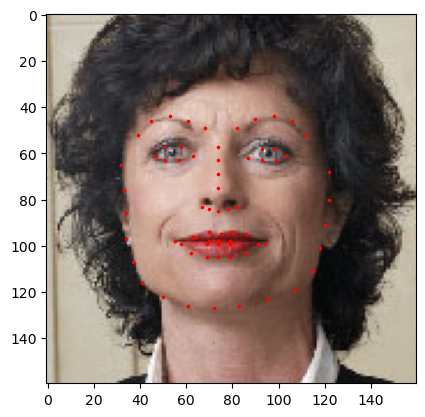

In [23]:
landmarks_frame = pd.read_csv('C:/Users/hmilab/Downloads/data/faces/face_landmarks.csv')

n = 65
img_name = landmarks_frame.iloc[n, 0]
landmarks = landmarks_frame.iloc[n, 1:]
landmarks = np.asarray(landmarks, dtype=float).reshape(-1, 2)

print('Image name: {}'.format(img_name))
print('Landmarks shape: {}'.format(landmarks.shape))
print('First 4 Landmarks: {}'.format(landmarks[:4]))

def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
    plt.pause(0.001)  # pause a bit so that plots are updated

plt.figure()
show_landmarks(io.imread(os.path.join('C:/Users/hmilab/Downloads/data/faces/', img_name)),
               landmarks)
plt.show()

### Dataset CLass

In [59]:
class FaceLandmarksDataset(Dataset):
    """Face Landmarks Dataset."""
    def __init__(self, csv_file, root_dir, transform = None):

        """
        Arguments:
            csv_file (string): Path to the csv file with annotations.
            root dir (string): Directory with all the images.
            Transform (callable, optional): Optional transform to be applied on a sample
        """

        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.landmarks_frame)
    
    def __getitem__ (self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.landmarks_frame.iloc[idx, 0])
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx, 1:]
        landmarks = np.array([landmarks], dtype = float).reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks}

        if self.transform:
            sample = self.transform(sample)

        return sample



##### Let’s instantiate this class and iterate through the data samples. We will print the sizes of first 4 samples and show their landmarks

0 (324, 215, 3) (68, 2)


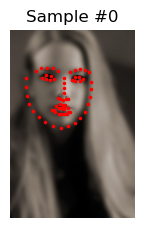

1 (500, 333, 3) (68, 2)


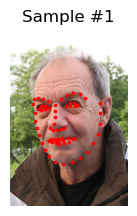

2 (250, 258, 3) (68, 2)


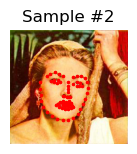

3 (434, 290, 3) (68, 2)


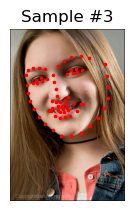

In [61]:
face_dataset = FaceLandmarksDataset(csv_file='C:/Users/hmilab/Downloads/data/faces/face_landmarks.csv', 
                                    root_dir='C:/Users/hmilab/Downloads/data/faces/')
fig = plt.figure()

for i, sample in enumerate(face_dataset):
    print(i, sample['image'].shape, sample['landmarks'].shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_landmarks(**sample)
    if i == 3:
        plt.show()
        break

## Transforms

In [62]:
tsfm = Transform(params)
transformed_sample = tsfm(sample)

NameError: name 'Transform' is not defined

##### we will be making three classes for transformation:
##### Rescale: to scale the image
##### RandomCrop: to crop from image randomly. This is data augmentation.
##### ToTensor: to convert the numpy images to torch images (we need to swap axes).

In [68]:
class Rescale(object):
    """Rescale the image in a sample to a given size.
    
    Args:
        outputsize (tuple or init): Desired output size. if tuple, output is 
        matched to output_size. if int, smaller of mage edges is matched 
        to output_size keeping aspect ratio te same
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h>w:
                new_h, new_w = self.output_size * h/w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w/h
        else:
            new_h, new_w =int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        #h and w are swapped for landmarks because for images
        # x and y are axis 1 and 0 respectively

        landmarks = landmarks * [new_w/w, new_h/h]

        return {'image': img, 'landmarks': landmarks}
    
class RandomCrop(object):
    """Crop randomly the image in a sample.
        
    Args:
         output_size (tuple or int): Desired output size. if int, square crop is made.
            
    """
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h-new_h+1)
        left = np.random.randint(0, w-new_w+1)

        image = image[top: top + new_h,
                          left: left+new_w]
        landmarks = landmarks - [left, top]

        return{'image': image, 'landmarks': landmarks}
    
class ToTensor(object):
    """ Convert ndarrays in sample to Tensors"""

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        #swap color axis because
        #numpy image : H x W x C
        #torch image : C x H x W

        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image), 
                'landmarks': torch.from_numpy(landmarks)}

### Compose transforms

#### Now, we apply the transforms on a sample.

#### Let’s say we want to rescale the shorter side of the image to 256 and then randomly crop a square of size 224 from it. i.e, we want to compose Rescale and RandomCrop transforms. torchvision.transforms.Compose is a simple callable class which allows us to do this

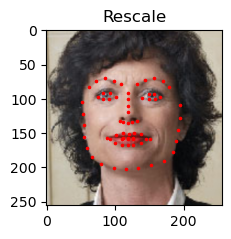

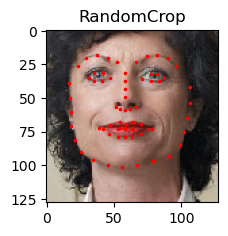

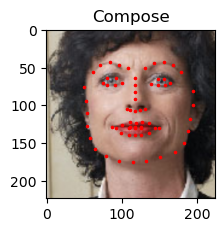

In [69]:
scale = Rescale(256)
crop = RandomCrop(128)

composed = transforms.Compose([Rescale(256),
                              RandomCrop(224)])

#Apply each of the above transforms on sample
fig = plt.figure()

sample = face_dataset[65]
for i, tsfrm in enumerate ([scale, crop, composed]):
    transformed_sample = tsfrm(sample)

    ax = plt.subplot(1, 3, i+ 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    show_landmarks(**transformed_sample)

plt.show()

## Iterating through the dataset 

Let’s put this all together to create a dataset with composed transforms. To summarize, every time this dataset is sampled:

An image is read from the file on the fly

Transforms are applied on the read image

Since one of the transforms is random, data is augmented on sampling

We can iterate over the created dataset with a for i in range loop as before.


In [70]:
transformed_dataset = FaceLandmarksDataset(csv_file= 'C:/Users/hmilab/Downloads/data/faces/face_landmarks.csv',
                                           root_dir = 'C:/Users/hmilab/Downloads/data/faces/',
                                           transform=transforms.Compose([
                                               Rescale(256),
                                               RandomCrop(224),
                                               ToTensor()
                                           ]))

for i, sample in enumerate(transformed_dataset):
    print(i, sample['image'].size(), sample['landmarks'].size())

    if i == 3:
        break

0 torch.Size([3, 224, 224]) torch.Size([68, 2])
1 torch.Size([3, 224, 224]) torch.Size([68, 2])
2 torch.Size([3, 224, 224]) torch.Size([68, 2])
3 torch.Size([3, 224, 224]) torch.Size([68, 2])


However, we are losing a lot of features by using a simple for loop to iterate over the data. In particular, we are missing out on:

Batching the data

Shuffling the data

Load the data in parallel using multiprocessing workers.

torch.utils.data.DataLoader is an iterator which provides all these features. Parameters used below should be clear. One parameter of interest is collate_fn. You can specify how exactly the samples need to be batched using collate_fn. However, default collate should work fine for most use cases.

0 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
1 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
2 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
3 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])


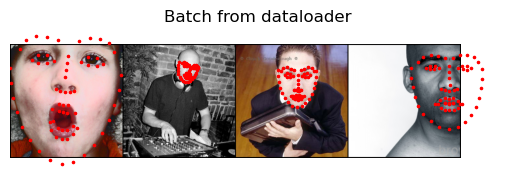

In [75]:
dataloader = DataLoader(transformed_dataset, batch_size=4, shuffle=True, num_workers=0)


#Helper function to show a batch

def show_landmarks_batch(sample_batched):
    """Show image with elements for a batch of samples."""
    images_batch, landmarks_batch = \
            sample_batched['image'], sample_batched['landmarks']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    grid_border_size = 2

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

    for i in range(batch_size):
        plt.scatter(landmarks_batch[i, :, 0].numpy() + i * im_size + (i + 1) * grid_border_size,
                    landmarks_batch[i, :, 1].numpy() + grid_border_size,
                    s=10, marker='.', c='r')
        
        plt.title('Batch from dataloader')

if __name__== '__main__':
    for i_batch, sample_batched in enumerate(dataloader):
        print(i_batch, sample_batched['image'].size(),
              sample_batched['landmarks'].size())
        
        #observe 4th batch and stop
        if i_batch == 3:
            plt.figure()
            show_landmarks_batch(sample_batched)
            plt.axis('off')
            plt.ioff()
            plt.show()
            break
